#                          Sentiment Analysis of Real-time Flipkart Product Reviews

## Objective :
The objective of this project is to classify customer reviews as positive or negative and understand the pain points of customers who write negative reviews. By analyzing the sentiment of reviews, we aim to gain insights into product features that contribute to customer satisfaction or dissatisfaction.


### Data Preprocessing

### 1. Import Libraries

In [5]:
import pandas as pd
import numpy as np
import re
import nltk

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


### 2. Load Data

In [15]:
df = pd.read_csv("/Users/dee/Downloads/reviews_data_dump/reviews_badminton/data.csv")

In [16]:
df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


### Exploratory Data Analysis (EDA)

In [52]:
df.columns


Index(['Reviewer Name', 'Review Title', 'Place of Review', 'Up Votes',
       'Down Votes', 'Month', 'Review text', 'Ratings', 'clean_text',
       'sentiment', 'review_length'],
      dtype='object')

In [53]:
df.dtypes


Reviewer Name       object
Review Title        object
Place of Review     object
Up Votes           float64
Down Votes         float64
Month               object
Review text         object
Ratings              int64
clean_text          object
sentiment            int64
review_length        int64
dtype: object

In [41]:
df.isnull().sum()


Reviewer Name        2
Review Title         2
Place of Review     42
Up Votes             2
Down Votes           2
Month              457
Review text          0
Ratings              0
clean_text           0
sentiment            0
dtype: int64

In [42]:
df = df.dropna(subset=["Review text", "Ratings"])
df = df.drop_duplicates()


In [17]:
df = df[df["Review text"].notna()]
df["Review text"] = df["Review text"].astype(str)

In [44]:
df["Ratings"].describe()
df["Ratings"].value_counts()


Ratings
5    5079
4    1744
1     766
3     615
2     306
Name: count, dtype: int64

In [47]:
%matplotlib inline

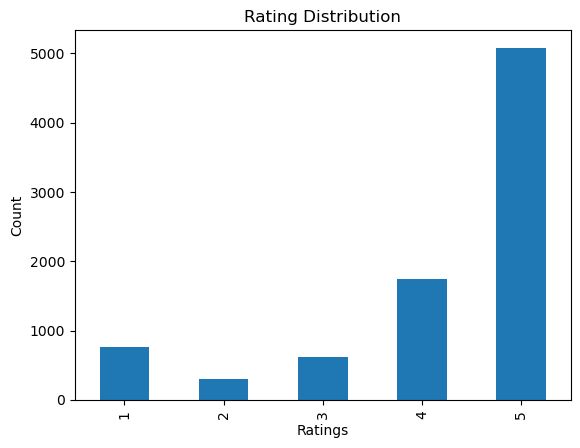

In [48]:
import matplotlib.pyplot as plt

df["Ratings"].value_counts().sort_index().plot(kind="bar")
plt.title("Rating Distribution")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.show()


In [50]:
df["review_length"] = df["Review text"].apply(lambda x: len(str(x).split()))
df["review_length"].describe()


count    8510.000000
mean        6.306698
std         7.726199
min         2.000000
25%         2.000000
50%         3.000000
75%         7.000000
max        96.000000
Name: review_length, dtype: float64

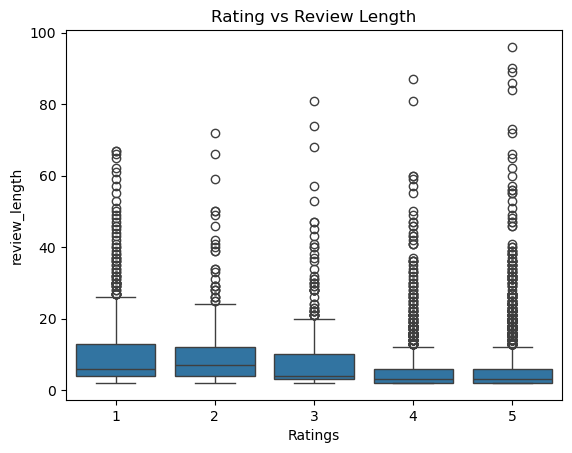

In [51]:
import seaborn as sns

sns.boxplot(x="Ratings", y="review_length", data=df)
plt.title("Rating vs Review Length")
plt.show()


### ### EDA Insights
- The dataset is positively skewed with more high ratings.
- Negative reviews tend to be longer and more descriptive.
- Some duplicate and missing entries were removed to ensure data quality.
- Outliers in review length were analyzed during EDA. Since longer reviews often contain detailed negative feedback and are not data errors, they were retained rather than removed.

### 3. Text Cleaning

In [19]:
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

df["clean_text"] = df["Review text"].apply(clean_text)
df["clean_text"] = df["clean_text"].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to /Users/dee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 4. Text Normalization (Lemmatization)

In [20]:
def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df["clean_text"] = df["clean_text"].apply(lemmatize_text)


### 5. Bag of Words (BoW)

In [21]:
bow_vectorizer = CountVectorizer(max_features=5000)

X_bow = bow_vectorizer.fit_transform(df["clean_text"])

X_bow.shape


(8510, 3039)

### 6. TF-IDF (Main Feature Set)

In [35]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)
)

X_tfidf = tfidf_vectorizer.fit_transform(df["clean_text"])

X_tfidf.shape


(8510, 5000)

### Modeling Approach

Assumption: 
X_tfidf → TF-IDF features;
X_bow → Bag of Words features;
df["rating"].

### 7. Create Target Variable (Sentiment)

In [25]:
# 1 = Positive (Rating >= 4), 0 = Negative (Rating <= 3)
df["sentiment"] = df["Ratings"].apply(lambda x: 1 if x >= 4 else 0)

y = df["sentiment"]


### 8. Train–Test Split

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,        # you can switch to X_bow if needed
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


### 9. Import Models & Metrics

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.metrics import f1_score, classification_report


### Train & Evaluate Models

### 10. Logistic Regression

In [28]:
lr = LogisticRegression(max_iter=1000)

lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

f1_lr = f1_score(y_test, y_pred_lr)

print("Logistic Regression F1-score:", f1_lr)


Logistic Regression F1-score: 0.923448275862069


### 11. Naive Bayes

In [29]:
nb = MultinomialNB()

nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)

f1_nb = f1_score(y_test, y_pred_nb)

print("Naive Bayes F1-score:", f1_nb)


Naive Bayes F1-score: 0.9205801104972375


### 12. Linear Support Vector Machine 

In [30]:
svm = LinearSVC()

svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

f1_svm = f1_score(y_test, y_pred_svm)

print("Linear SVM F1-score:", f1_svm)


Linear SVM F1-score: 0.921830985915493


### Compare Model Performance

In [31]:
model_results = pd.DataFrame({
    "Model": ["Naive Bayes", "Logistic Regression", "Linear SVM"],
    "F1-Score": [f1_nb, f1_lr, f1_svm]
})

model_results.sort_values(by="F1-Score", ascending=False)


,Model,F1-Score
1,Logistic Regression,0.923448
2,Linear SVM,0.921831
0,Naive Bayes,0.920580


### Detailed Evaluation

In [32]:
print(classification_report(y_test, y_pred_svm))


              precision    recall  f1-score   support

           0       0.75      0.51      0.61       337
           1       0.89      0.96      0.92      1365

    accuracy                           0.87      1702
   macro avg       0.82      0.73      0.76      1702
weighted avg       0.86      0.87      0.86      1702



### F1-score was chosen as the evaluation metric because it balances precision and recall, making it suitable for sentiment classification where class imbalance exists

In [37]:
import joblib

# Save model and vectorizer
joblib.dump(lr, "sentiment_model.pkl")
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

In [38]:
import os
print(os.path.getsize("sentiment_model.pkl"))
print(os.path.getsize("tfidf_vectorizer.pkl"))


40863
207315
